In [1]:
import numpy as np
import os, sys
from scipy import ndimage
%pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


2024-03-21 03:03:10.112690: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 03:03:10.524083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 03:03:10.524150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 03:03:10.605324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 03:03:10.777651: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 03:03:10.779176: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import os
from configs.settings import BASE_DIR
folder = os.path.join(BASE_DIR, 'papaya_dataset_/papaya_dataset_01/')
#mudei essas linhas de baixo pois estava em 120
image_width = 64
image_height = 64
channels = 3

train_files = []
i=0
for estado in ['mature', 'partiallymature', 'unmature']:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(estado)) if os.path.isfile(os.path.join(folder + '/' + str(estado), f))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),dtype=np.float32)
y_dataset = []

i = 0
for estado in ['mature', 'partiallymature', 'unmature']:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(estado)) if os.path.isfile(os.path.join(folder + '/' + str(estado), f))]
    for _file in onlyfiles:
        ###
        img = cv2.imread(os.path.join(folder, estado, _file))
        img_resized = cv2.resize(img, (image_width, image_height))

        dataset[i] = img_resized
        mapping = {'mature': 0, 'partiallymature': 1, 'unmature': 2}
        y_dataset.append(mapping[estado])
        ###
        i += 1
        if i % 250 == 0:
            print("%d images to array" % i)
print("All images to array!")



250 images to array
All images to array!


'

In [3]:
# normalize
dataset = dataset.astype('float32')
dataset /= 255

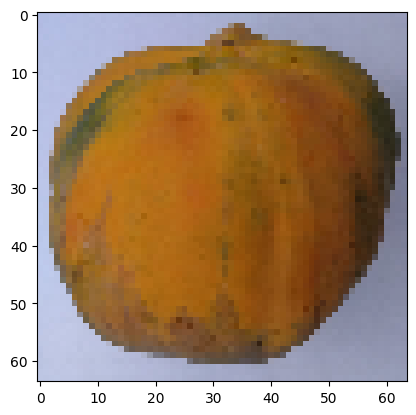

In [4]:
pixels = np.array(dataset[0], dtype='float32')
#pixels = pixels.reshape((64, 64, 3))
plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB))
plt.show()
#print(scaled_labels[0])

In [5]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

3


In [6]:
# splitting into training and test
#Splitting
X_train, X_test, y_train, y_test = train_test_split(dataset, y_dataset_, test_size=0.2)
print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 240, Test set size: 60


In [7]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=90, shear_range=0.2, horizontal_flip=True, fill_mode='nearest')

datagen.fit(X_train)

In [8]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape=(64, 64, 3)))
model.add(tf.keras.layers.Conv2D(filters= 128, kernel_size=(3, 3), activation='relu', strides=(1,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters= 64, kernel_size=(2, 2), activation='relu', strides=(1,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters= 32, kernel_size=(1, 1), activation='relu', strides=(1,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 64, activation='relu'))
model.add(Dropout(0.1))
model.add(tf.keras.layers.Dense(units = 3, activation='softmax', name = 'saida'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 64, 64, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 10)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks = [early_stopping])

Epoch 1/100


2024-03-21 03:03:34.062854: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15745024 exceeds 10% of free system memory.
2024-03-21 03:03:34.080234: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62980096 exceeds 10% of free system memory.
2024-03-21 03:03:34.159533: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15745024 exceeds 10% of free system memory.
2024-03-21 03:03:34.168988: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15745024 exceeds 10% of free system memory.
2024-03-21 03:03:34.205651: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19180800 exceeds 10% of free system memory.


6/6 [==============================] - 4s 363ms/step - loss: 0.9215 - accuracy: 0.5833 - val_loss: 1.0819 - val_accuracy: 0.3958
Epoch 2/100
6/6 [==============================] - 2s 279ms/step - loss: 0.3756 - accuracy: 0.8542 - val_loss: 1.1486 - val_accuracy: 0.3958
Epoch 3/100
6/6 [==============================] - 2s 288ms/step - loss: 0.2182 - accuracy: 0.9115 - val_loss: 1.4885 - val_accuracy: 0.6667
Epoch 4/100
6/6 [==============================] - 2s 288ms/step - loss: 0.2229 - accuracy: 0.9219 - val_loss: 1.1163 - val_accuracy: 0.5417
Epoch 5/100
6/6 [==============================] - 2s 283ms/step - loss: 0.1160 - accuracy: 0.9635 - val_loss: 1.7060 - val_accuracy: 0.3125
Epoch 6/100
6/6 [==============================] - 2s 283ms/step - loss: 0.1342 - accuracy: 0.9479 - val_loss: 1.0203 - val_accuracy: 0.6667
Epoch 7/100
6/6 [==============================] - 2s 284ms/step - loss: 0.1062 - accuracy: 0.9688 - val_loss: 1.0331 - val_accuracy: 0.6667
Epoch 8/100
6/6 [========

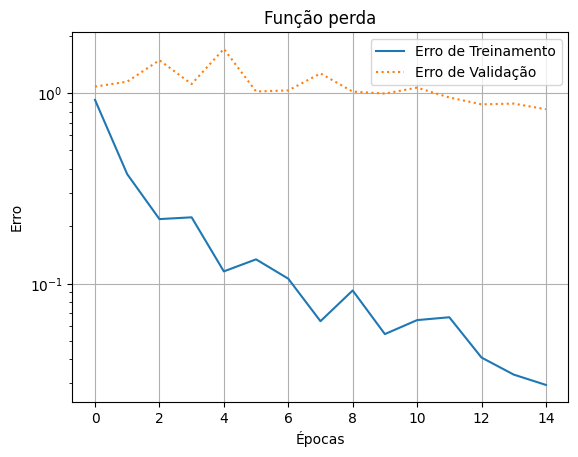

In [11]:
# Visualizando o ERRO de treinamento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], ':')
plt.title('Função perda')
plt.yscale('log')
plt.ylabel('Erro')
plt.xlabel('Épocas')
plt.legend(['Erro de Treinamento', 'Erro de Validação'])
plt.grid(True)
plt.show()

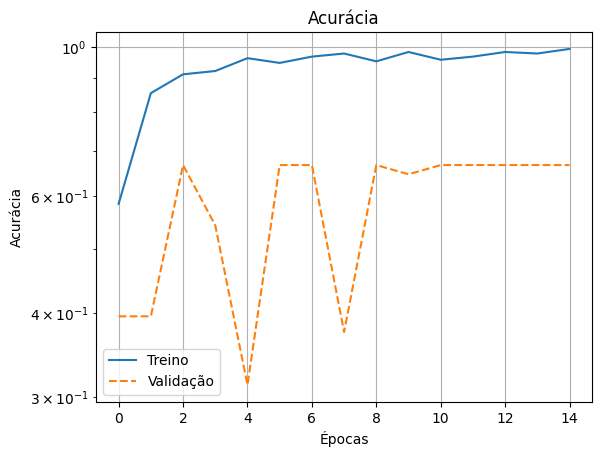

In [12]:
# Plotando o treinamento e a validação da accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '--')
plt.yscale("log")
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'])
plt.grid(True)
plt.show()

In [13]:
preds = model.predict(X_test)

2/2 [==============================] - 0s 67ms/step


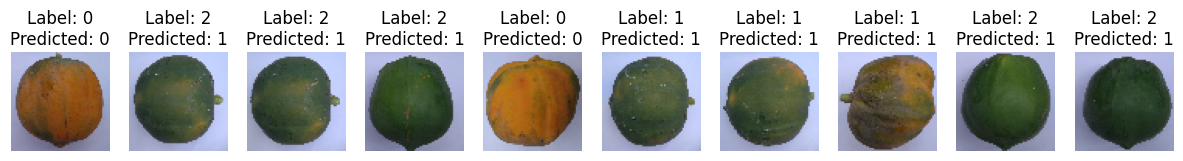

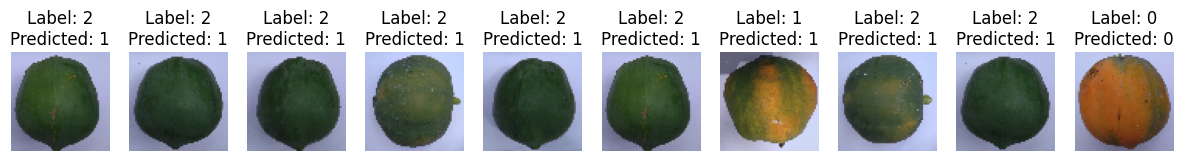

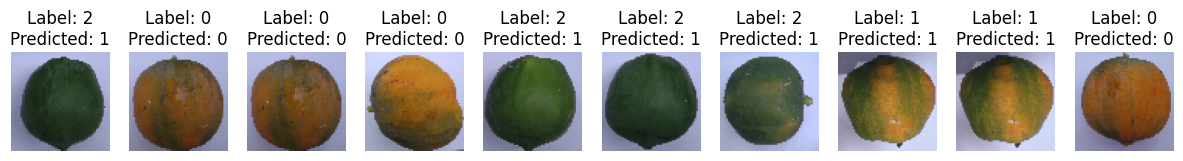

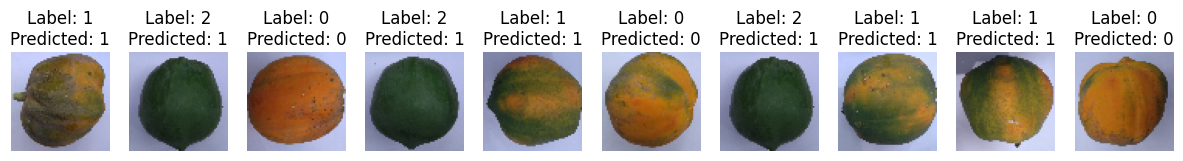

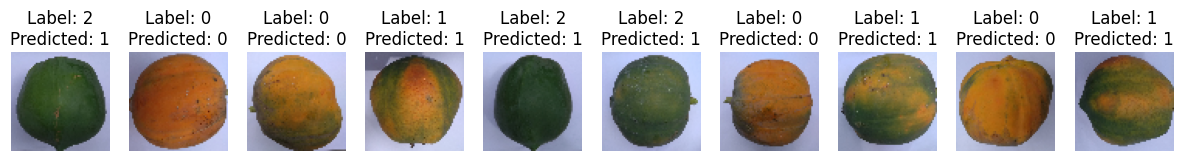

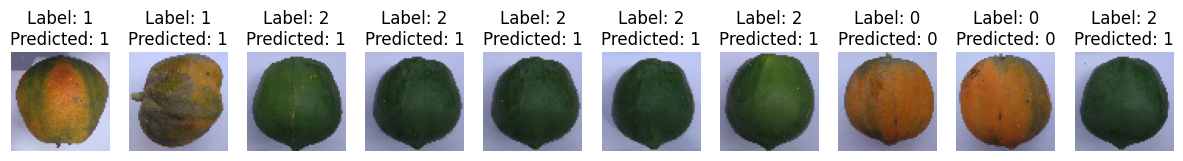

In [14]:
import matplotlib.pyplot as plt

n = 10
total_images = len(X_test)
for t in range(total_images // n):
    plt.figure(figsize=(15,15))
    for i in range(n*t, min(n*(t+1), total_images)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Label: {}\nPredicted: {}'.format(np.argmax(y_test[i]), np.argmax(preds[i])))
        plt.axis('off')
    plt.show()


In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

Confusion matrix, without normalization
[[16  0  0]
 [ 0 15  0]
 [ 0 29  0]]


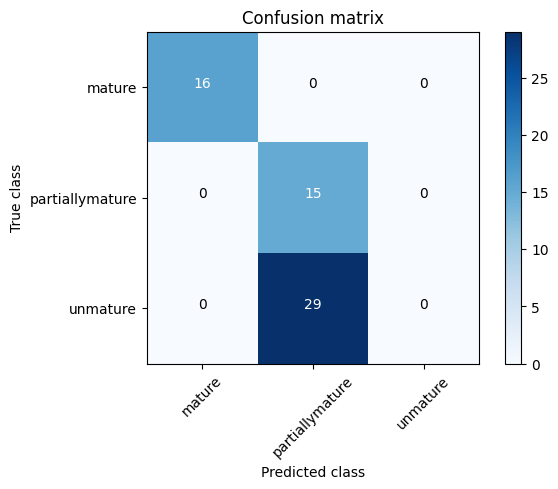

In [16]:
# Plot non-normalized confusion matrix
#y_test_ = np.apply_along_axis(np.argmax, 1, y_test)
#preds_ = np.apply_along_axis(np.argmax, 1, preds)
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plt.figure()
plot_confusion_matrix(cm, classes=['mature', 'partiallymature', 'unmature'], title='Confusion matrix')
plt.show()

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: {:.2f}%".format(accuracy * 100))

2/2 [==============================] - 0s 84ms/step - loss: 1.1075 - accuracy: 0.5167
Loss:  1.1074950695037842
Accuracy: 51.67%


In [18]:
# Convertendo as previsões e os rótulos de volta para as classes originais
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

In [19]:
# Calcular acurácia
accuracy = accuracy_score(y_test_, preds_)
print("Acurácia:", accuracy)

Acurácia: 0.5166666666666667


In [20]:
# Calcular precisão
precision = precision_score(y_test_, preds_, average='macro')
print("Precisão:", precision)

Precisão: 0.44696969696969696


/home/emanuel/Área de Trabalho/UFERSA-2023.2/PAPAYA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# Calcular recall
recall = recall_score(y_test_, preds_, average='macro')
print("Recall:", recall)

Recall: 0.6666666666666666


In [22]:
# Calcular F1 score
f1 = f1_score(y_test_, preds_, average='macro')
print("F1-score:", f1)

F1-score: 0.5028248587570622


In [23]:
# saving model
model.save(os.path.join(BASE_DIR, 'modelfile.h5'))

/home/emanuel/Área de Trabalho/UFERSA-2023.2/PAPAYA/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
%pip install pandas
import pandas as pd

# Supondo que 'history' seja o objeto que você deseja salvar, conforme mencionado anteriormente

# Convertendo o histórico de treinamento em um DataFrame do Pandas
historico = pd.DataFrame(history.history)

# Salvando o DataFrame em um arquivo CSV
historico.to_csv(os.path.join(BASE_DIR, 'historico.csv'), index=False)


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
